In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!unzip -q "/content/drive/MyDrive/archive.zip" -d /content/chexpert

In [ ]:
import os

# Check folder
print("Files in extracted folder:")
print(os.listdir('/content/chexpert'))

# Check how many images exist
train_image_count = sum(len(files) for _, _, files in os.walk("/content/chexpert/train"))
print("Train images:", train_image_count)

Files in extracted folder:
['valid.csv', 'train.csv', 'valid', 'train']
Train images: 223415


                         Label     1.0    0.0   -1.0     NaN  Valid (0 or 1)  \
0              Support Devices  116001   6137   1079  100197          122138   
1             Pleural Effusion   86187  35396  11628   90203          121583   
2                 Lung Opacity  105581   6599   5598  105636          112180   
3                 Pneumothorax   19448  56341   3145  144480           75789   
4                        Edema   52246  20726  12984  137458           72972   
5                Consolidation   14783  28097  27742  152792           42880   
6                 Cardiomegaly   27000  11116   8087  177211           38116   
7                  Atelectasis   33376   1328  33739  154971           34704   
8   Enlarged Cardiomediastinum   10798  21638  12403  178575           32436   
9                   No Finding   22381      0      0  201033           22381   
10                    Fracture    9040   2512    642  211220           11552   
11                 Lung Lesion    9186  

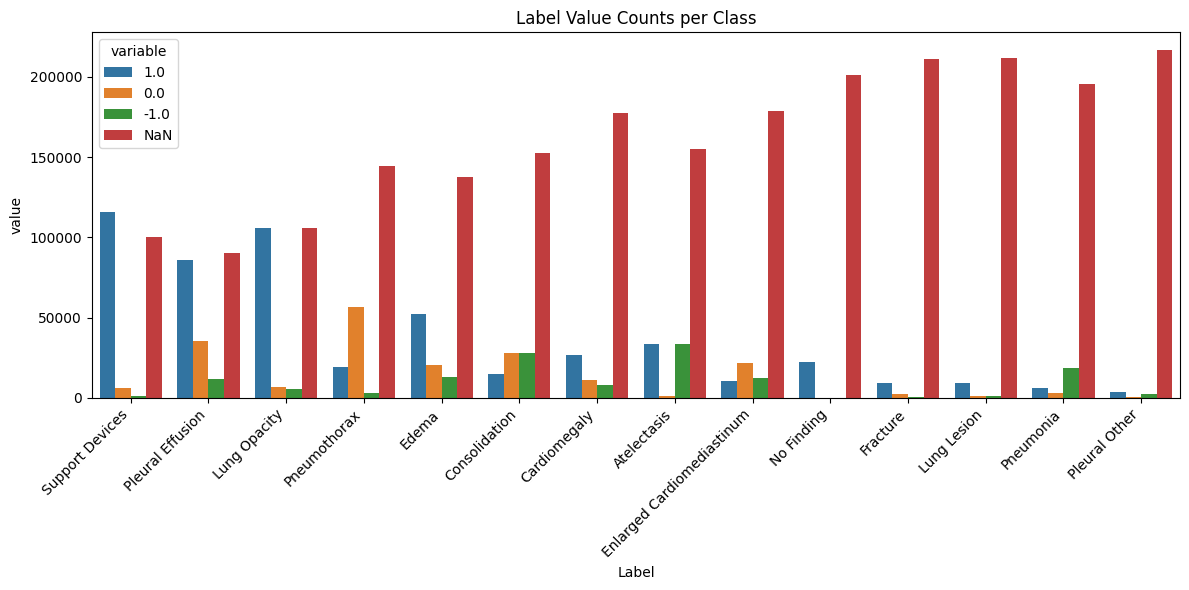

In [ ]:
import pandas as pd
import numpy as np

# Load dataset
df = pd.read_csv("/content/chexpert/train.csv")

# All 14 CheXpert labels (you can extract dynamically too)
all_labels = [
    "No Finding", "Enlarged Cardiomediastinum", "Cardiomegaly", "Lung Opacity", "Lung Lesion",
    "Edema", "Consolidation", "Pneumonia", "Atelectasis", "Pneumothorax", "Pleural Effusion",
    "Pleural Other", "Fracture", "Support Devices"
]

# Count distribution per label
distribution = {
    "Label": [],
    "1.0": [],
    "0.0": [],
    "-1.0": [],
    "NaN": [],
    "Valid (0 or 1)": [],
    "Total Non-NaN": []
}

for label in all_labels:
    col = df[label]
    distribution["Label"].append(label)
    distribution["1.0"].append((col == 1.0).sum())
    distribution["0.0"].append((col == 0.0).sum())
    distribution["-1.0"].append((col == -1.0).sum())
    distribution["NaN"].append(col.isna().sum())
    distribution["Valid (0 or 1)"].append(((col == 1.0) | (col == 0.0)).sum())
    distribution["Total Non-NaN"].append(col.notna().sum())

# Convert to DataFrame for nice viewing
label_stats = pd.DataFrame(distribution)

# Sort by number of valid samples (1.0 or 0.0)
label_stats = label_stats.sort_values(by="Valid (0 or 1)", ascending=False).reset_index(drop=True)

# Display it
import seaborn as sns
import matplotlib.pyplot as plt

print(label_stats)

# Optional: visualize distribution
label_stats_melted = label_stats.melt(id_vars="Label", value_vars=["1.0", "0.0", "-1.0", "NaN"])
plt.figure(figsize=(12, 6))
sns.barplot(data=label_stats_melted, x="Label", y="value", hue="variable")
plt.xticks(rotation=45, ha="right")
plt.title("Label Value Counts per Class")
plt.tight_layout()
plt.show()

In [ ]:
from pathlib import Path

# Load metadata
csv_path = "/content/chexpert/train.csv"
df = pd.read_csv(csv_path)

# Add full image path
df["filepath"] = df["Path"].apply(lambda x: str(Path("/content/chexpert") / Path(x).relative_to("CheXpert-v1.0-small")))

# Filter to frontal images only
df = df[df["Frontal/Lateral"] == "Frontal"]

# Select diagnoses
target_labels = ["Pleural Effusion", "Edema", "Cardiomegaly"] # Tried a few times, going for this combo due to fair amount of data and balance.

# Replace -1 with 0 (treat uncertainty as negative)
df[target_labels] = df[target_labels].replace(-1.0, 0.0)

# Drop rows where any of the selected labels are NaN
df = df.dropna(subset=target_labels)

# Drop rows where image doesn't exist
df = df[df["filepath"].apply(lambda x: Path(x).is_file())]

# Show filtered shape and label distributions
print("Filtered shape:", df.shape)
display(df[target_labels].apply(pd.Series.value_counts).fillna(0).astype(int))


Filtered shape: (13180, 20)


<ipython-input-28-1d4bc7bcd9cd>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[target_labels] = df[target_labels].replace(-1.0, 0.0)


,Pleural Effusion,Edema,Cardiomegaly
1.0,8745,8009,9278
0.0,4435,5171,3902


In [ ]:
from sklearn.model_selection import train_test_split

# Train/val split (80/20)
train_df, val_df = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
)

# Reset index (optional, for cleanliness)
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

print(f"Train shape: {train_df.shape}")
print(f"Validation shape: {val_df.shape}")

Train shape: (10544, 20)
Validation shape: (2636, 20)


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Image size and batch size
IMG_SIZE = (256, 256)
BATCH_SIZE = 32

# Initialize generator
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

# Training generator
train_generator = datagen.flow_from_dataframe(
    dataframe=df,
    x_col='filepath',
    y_col=target_labels,
    target_size=IMG_SIZE,
    color_mode='grayscale',
    class_mode='raw',  # Raw gives continuous/multi-label outputs
    batch_size=BATCH_SIZE,
    shuffle=True,
    subset='training'
)

# Validation generator
val_generator = datagen.flow_from_dataframe(
    dataframe=df,
    x_col='filepath',
    y_col=target_labels,
    target_size=IMG_SIZE,
    color_mode='grayscale',
    class_mode='raw',
    batch_size=BATCH_SIZE,
    shuffle=False,
    subset='validation'
)


Found 10544 validated image filenames.
Found 2636 validated image filenames.


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Baseline model (v1)
def create_cnn_model(input_shape=(256, 256, 1), num_classes=3):
    model = models.Sequential([
        layers.Input(shape=input_shape),

        layers.Conv2D(16, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),

        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),

        layers.Dense(num_classes, activation='sigmoid')  # Multi-label classification
    ])

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

# Create model instance
model = create_cnn_model()
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 256, 256, 16)   │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 128, 128, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 128, 128, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     8,388,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,412,419 (32.09 MB)

 Trainable params: 8,412,419 (32.09 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)
]

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=5,
    callbacks=callbacks
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
330/330 ━━━━━━━━━━━━━━━━━━━━ 58s 153ms/step - accuracy: 0.4179 - loss: 0.6202 - val_accuracy: 0.4165 - val_loss: 0.5398
Epoch 2/5
330/330 ━━━━━━━━━━━━━━━━━━━━ 51s 75ms/step - accuracy: 0.4657 - loss: 0.5462 - val_accuracy: 0.5175 - val_loss: 0.5185
Epoch 3/5
330/330 ━━━━━━━━━━━━━━━━━━━━ 42s 77ms/step - accuracy: 0.4709 - loss: 0.5318 - val_accuracy: 0.5061 - val_loss: 0.5130
Epoch 4/5
330/330 ━━━━━━━━━━━━━━━━━━━━ 24s 73ms/step - accuracy: 0.5431 - loss: 0.5010 - val_accuracy: 0.5178 - val_loss: 0.5140
Epoch 5/5
330/330 ━━━━━━━━━━━━━━━━━━━━ 41s 73ms/step - accuracy: 0.5100 - loss: 0.4815 - val_accuracy: 0.4856 - val_loss: 0.5199


In [ ]:
# Evaluate loss and accuracy
val_loss, val_acc = model.evaluate(val_generator)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")


83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - accuracy: 0.4813 - loss: 0.5422
Validation Loss: 0.5199
Validation Accuracy: 0.4856


In [ ]:
import numpy as np
from sklearn.metrics import classification_report, roc_auc_score

# Predict probabilities
y_pred_prob = model.predict(val_generator)

# Get true labels
y_true = val_generator.labels

# Threshold probabilities to get binary outputs
y_pred = (y_pred_prob > 0.5).astype(int)


83/83 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step


In [ ]:
from sklearn.metrics import classification_report

target_labels = ['Pleural Effusion', 'Edema', 'Cardiomegaly']

print(classification_report(y_true, y_pred, target_names=target_labels))


                  precision    recall  f1-score   support

Pleural Effusion       0.77      0.88      0.82      1644
           Edema       0.75      0.81      0.78      1535
    Cardiomegaly       0.79      0.91      0.85      1865

       micro avg       0.78      0.87      0.82      5044
       macro avg       0.77      0.87      0.82      5044
    weighted avg       0.78      0.87      0.82      5044
     samples avg       0.63      0.71      0.64      5044



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
for i, label in enumerate(target_labels):
    auc = roc_auc_score(y_true[:, i], y_pred_prob[:, i])
    print(f"{label} AUC: {auc:.4f}")


Pleural Effusion AUC: 0.8156
Edema AUC: 0.7938
Cardiomegaly AUC: 0.7490


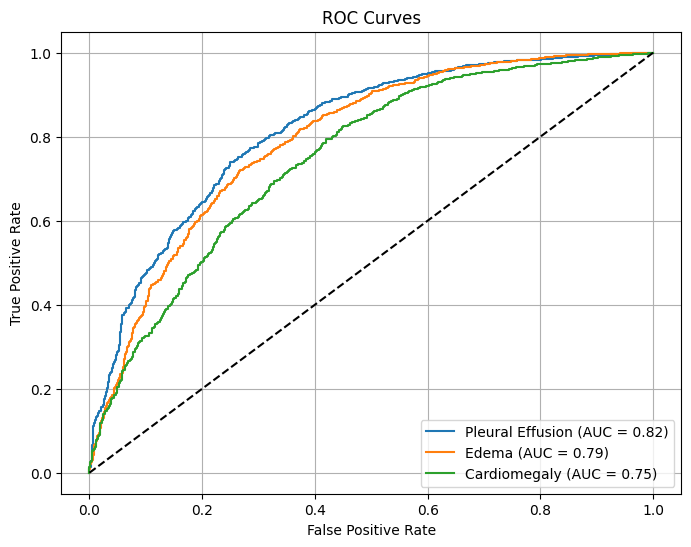

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

plt.figure(figsize=(8, 6))
for i, label in enumerate(target_labels):
    fpr, tpr, _ = roc_curve(y_true[:, i], y_pred_prob[:, i])
    plt.plot(fpr, tpr, label=f"{label} (AUC = {roc_auc_score(y_true[:, i], y_pred_prob[:, i]):.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend()
plt.grid(True)
plt.show()


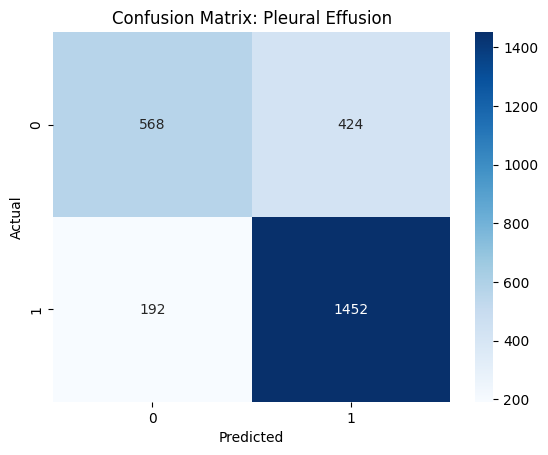

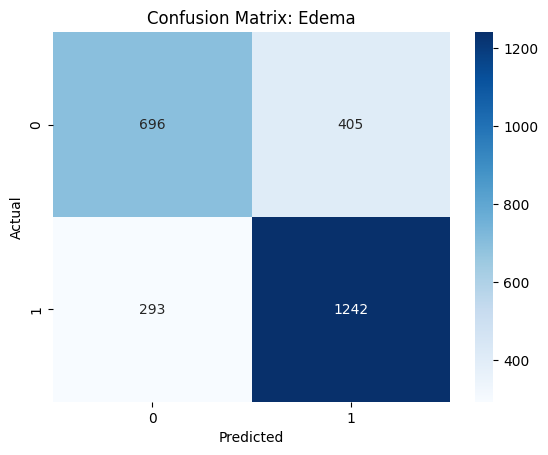

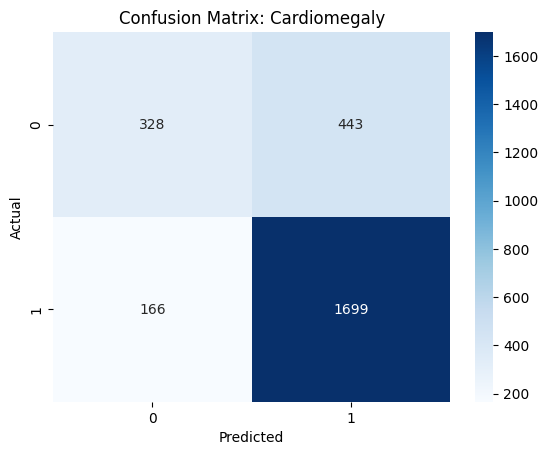

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

for i, label in enumerate(target_labels):
    cm = confusion_matrix(y_true[:, i], y_pred[:, i])
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix: {label}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()
